In [1]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
import numpy as np
import pandas as pd
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def import *
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
import h5py
from statsmodels.tsa.stattools import acf
%matplotlib notebook

save_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/FilamentTipAutocorrelation'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
# Create a folder for storing Publication figures
# Check which platform
if platform == "linux" or platform == "linux2":
    print("linux system")
    ROOT_PATH = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'

elif platform == 'darwin':
    print("OSX system")
    ROOT_PATH = '/Users/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'

publication_figures = os.path.join(ROOT_PATH,'Figure2')
import _figure_parameters

linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

In [22]:
# Lognormal activity, Lacry distribution 
data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/Lognormal_distribution'

# Deterministic activity, Lacry distribution
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/DistributedActivity_LacryType/NeckHead_scalefactor_2'

# Deterministic activity, Uniform distribution
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/DistributedActivitySims_2022_11_11'

# Deterministic activity , Point distribution
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_widerICS_FINAL_2021-12-23'

# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/deterministic_activity'
# data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/lognormal_activity'

sim_folders = os.listdir(data_folder)

print(len(sim_folders))

17


In [36]:
# Autocorrelation calculation parameters

n_cycles = 40 # No:of cycles we want to calculate auto-correlation over

start_cycle = 100 # No:of cycles to neglect to remove transients

In [38]:
save_data = True
overwrite = False

data_file = 'Filament_tip_decorrelation_lognormal_lacry.csv'

save_file = os.path.join(save_folder, data_file)

if not os.path.exists(save_file) or overwrite==True:

    df_ensemble = pd.DataFrame({})  # Holds the data over all simulations

    for folder in sim_folders:
        # each sim_folder corresponds to a unique parameter set

        curr_folder = os.path.join(data_folder, folder)

        min_common_time = np.nan
        max_common_time = 0

        file_counter = 0

        time_array = {}
        analysis_file_array = {}
        base_tip_angles = {}
        base_tip_distance = {}

        sim_files = [file for file in os.listdir(curr_folder) if file.endswith('.hdf5')]

        for file in sim_files:

            # each .hdf5 file corresponds to a simulation run
            file_name = file[:-5]
            analysis_file = os.path.join('Analysis',file_name + '_analysis.csv')
            df_analysis = pd.read_csv(os.path.join(curr_folder, analysis_file))

            sim_complete = df_analysis['simulation completed'][0]

            if sim_complete:
                
                    # Load simulation data
                filament = analysis.analysisTools(file = os.path.join(curr_folder, file))
                
                start_index = filament.cycle_to_index(start_cycle)
                
                time = filament.Time[start_index:]
                
                min_common_time = min(np.max(time), min_common_time)
                max_common_time = max(np.min(time), max_common_time)
                time_array[file_counter] = time

                analysis_file_array[file_counter] = analysis_file
                
                filament.compute_base_tip_angle()
                filament.compute_tip_radial_pos()
                
                base_tip_angles[file_counter] = filament.derived_data['base tip angle'][start_index:]
                
                base_tip_distance[file_counter] = filament.derived_data['tip distance'][start_index:]

                file_counter+=1
                
                n_time = int(len(time)/2)


        if file_counter > 0:                
            # Create a common time-array
            common_time_array = np.linspace(max_common_time, min_common_time, n_time)
            
            delta_t = np.nanmean(common_time_array[1:]-common_time_array[0:-1])
            

            for ii in range(file_counter):

              
                analysis_file = analysis_file_array[ii]
                df_analysis = pd.read_csv(os.path.join(curr_folder, analysis_file))
                activity_timescale = df_analysis[' activity time scale']
                
                activity_type = df_analysis['activity type']
                   
                    
                n_lags = int(n_cycles*activity_timescale/delta_t)

                time = time_array[ii]
                
                
                base_tip_array = base_tip_angles[ii]
                
                base_tip_distance_array = base_tip_distance[ii]
                
                data_func = interpolate.interp1d(time, base_tip_array, kind = 'linear')
                
                data_func_dist = interpolate.interp1d(time, base_tip_distance_array, kind = 'linear')
                
                # Interpolate the data to a common time array
                base_tip_sampled = np.array(data_func(common_time_array))
                
                base_tip_distance_sampled = np.array(data_func_dist(common_time_array))
                
                lags = delta_t*np.arange(0, n_lags+1, 1)
                

                # Calculate the autocorrelation for the base-tip angles
                acf_array = acf(base_tip_sampled, nlags = n_lags, qstat=False, fft=True, alpha=None, missing='none')
                
                acf_distance_array = acf(base_tip_distance_sampled, nlags = n_lags, qstat=False, fft=True, alpha=None, missing='none')
                
                # Save the interpolated data as well as other filament parameters in a new dataframe
                base_tip_dict = {'Lags': lags, 'Initial condition': np.repeat(ii, n_lags+1),
                                   'Base-tip angle autocorrelation': acf_array, 'Base-tip distance autocorrelation':acf_distance_array}
                
                filament_params_dict = {column:np.repeat(df_analysis[column][0], n_lags+1) for column in df_analysis.columns}

                df_sampled = pd.DataFrame({**base_tip_dict, **filament_params_dict})


                # Add this to the master data frame
                df_ensemble = pd.concat([df_ensemble, df_sampled], ignore_index=True)
    
    
    if save_data:
        df_ensemble.to_csv(save_file)


else:
    print('Loading data from file ...')
    df_ensemble = pd.read_csv(save_file)


Loading data from file ...


## Rescale the time array based on the relevant time-scale

In [39]:
activity_type = np.unique(df_ensemble['activity type'])[0]
sim_type = np.unique(df_ensemble['simulation type'])[0]

if activity_type == 'lognormal':
    
    T_ext_median = np.unique(df_ensemble[' activity time scale'])
    T_comp_median = T_ext_median/EXT_COMP_SCALEFACTOR


    T_ext_mean_theory = T_ext_median*np.exp(SIGMA_EXT**2/2)
    T_comp_mean_theory = T_comp_median*np.exp(SIGMA_COMP**2/2)

    activity_timescale = T_ext_mean_theory + T_comp_mean_theory
    
    
    df_ensemble['Lags (cycle)'] = df_ensemble['Lags']/activity_timescale

else:
    df_ensemble['Lags (cycle)'] = df_ensemble['Lags']/df_ensemble[' activity time scale']

    

In [40]:
# Choose the activity values to plot

activity_numbers = np.unique(df_ensemble['activity number'])
print(activity_numbers)

activity_numbers_plot = activity_numbers[::3]

print(len(activity_numbers_plot))

[  86.1056      339.89052632  403.33675789  466.78298947  530.22922105
  593.67545263  657.12168421  720.56791579  784.01414737  847.46037895
  910.90661053  974.35284211 1037.79907368 1101.24530526 1164.69153684
 1228.13776842 1291.584     ]
6


In [41]:
# Make a subset of the dataframe 
df_subset = pd.DataFrame({})
for value in activity_numbers_plot:
    
    df_temp = df_ensemble.loc[df_ensemble['activity number']==value]
    
    df_subset = pd.concat([df_subset, df_temp])
    

<IPython.core.display.Javascript object>


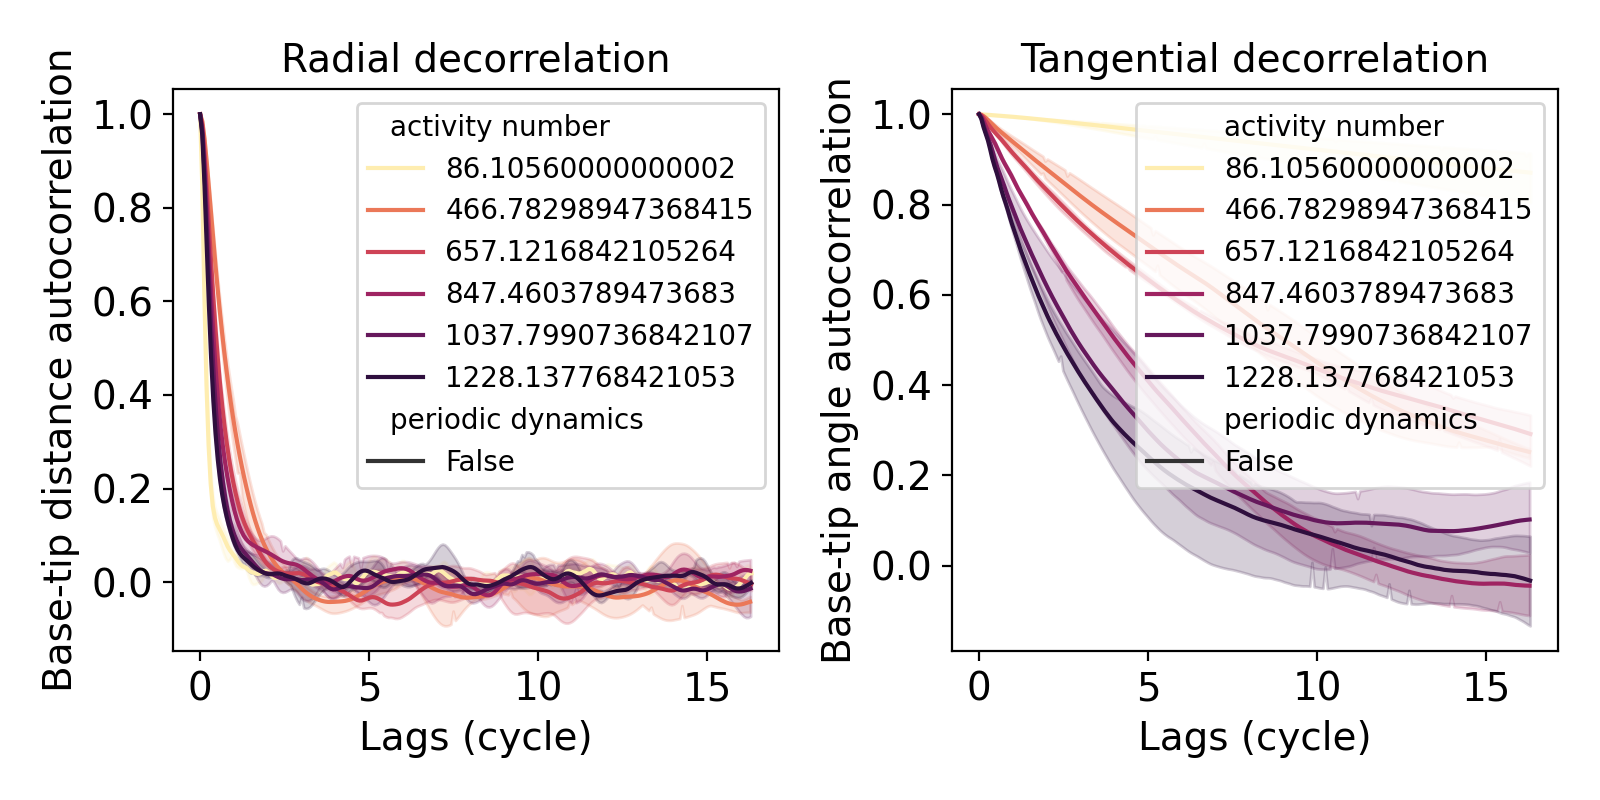

In [42]:
# Plot the data
save_fig = True


fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

title = 'BaseTipAngle_Radius_autocorrelation_cycles_{}_{}'.format(sim_type, activity_type)

sns.lineplot(data = df_subset, x = 'Lags (cycle)', y = 'Base-tip distance autocorrelation', 
             hue = 'activity number', style = 'periodic dynamics', ci = 95, palette = cmocean.cm.matter, ax = ax0)
ax0.set_title('Radial decorrelation')

sns.lineplot(data = df_subset, x = 'Lags (cycle)', y = 'Base-tip angle autocorrelation', 
             hue = 'activity number', style = 'periodic dynamics', ci = 95, palette = cmocean.cm.matter, ax = ax1)
ax1.set_title('Tangential decorrelation')

plt.legend()
plt.tight_layout()
if save_fig:
    
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

<IPython.core.display.Javascript object>


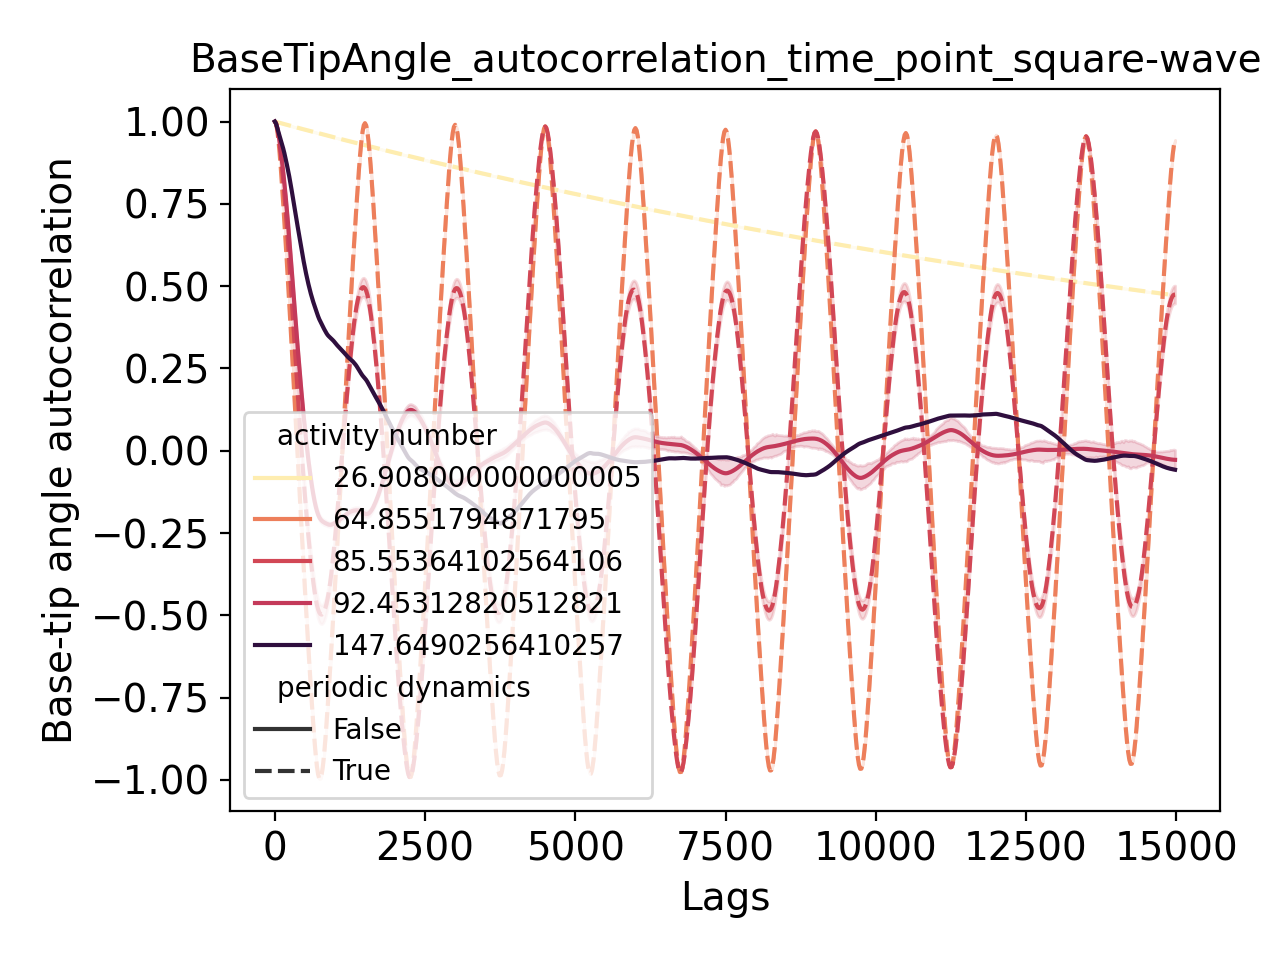

In [34]:
# Plot the data
save_fig = True
plt.figure()
title = 'BaseTipAngle_autocorrelation_time_{}_{}'.format(sim_type, activity_type)
sns.lineplot(data = df_ensemble, x = 'Lags', y = 'Base-tip angle autocorrelation', 
             hue = 'activity number', style = 'periodic dynamics', ci = 95, palette = cmocean.cm.matter)

plt.title(title)
plt.tight_layout()
if save_fig:
    
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

In [7]:
df_ensemble

,Lags,Initial condition,Base-tip angle autocorrelation,Base-tip distance autocorrelation,Unnamed: 0,N particles,radius,bond length,spring constant,kappa_hat,...,period,threshold index,simulation completed,periodic dynamics,max unique locations,activity cycles completed,search efficiency,activity number,filament behavior,Lags (cycle)
0,0.000000,0,1.000000,NaN,0,32,1,2.1,25,6.25,...,1.0,82,True,True,1,500,0.00073,26.908000,1-period,0.000000
1,20.001333,0,0.998996,NaN,0,32,1,2.1,25,6.25,...,1.0,82,True,True,1,500,0.00073,26.908000,1-period,0.026668
2,40.002667,0,0.997990,NaN,0,32,1,2.1,25,6.25,...,1.0,82,True,True,1,500,0.00073,26.908000,1-period,0.053337
3,60.004000,0,0.996980,NaN,0,32,1,2.1,25,6.25,...,1.0,82,True,True,1,500,0.00073,26.908000,1-period,0.080005
4,80.005334,0,0.995966,NaN,0,32,1,2.1,25,6.25,...,1.0,82,True,True,1,500,0.00073,26.908000,1-period,0.106674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30745,14900.993400,0,-0.054732,NaN,0,32,1,2.1,25,6.25,...,NaN,0,True,False,1459,500,0.01494,147.649026,aperiodic,19.867991
30746,14920.994733,0,-0.055475,NaN,0,32,1,2.1,25,6.25,...,NaN,0,True,False,1459,500,0.01494,147.649026,aperiodic,19.894660
30747,14940.996066,0,-0.056273,NaN,0,32,1,2.1,25,6.25,...,NaN,0,True,False,1459,500,0.01494,147.649026,aperiodic,19.921328
30748,14960.997400,0,-0.057078,NaN,0,32,1,2.1,25,6.25,...,NaN,0,True,False,1459,500,0.01494,147.649026,aperiodic,19.947997


In [8]:
file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test/deterministic_activity/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.718_activityTime_750_simType_point/SimResults_00_.hdf5'

filament = analysis.analysisTools(file = file)


Attribute not found


In [9]:
filament.compute_tip_radial_pos()

In [10]:
tip_radial_pos = filament.derived_data['tip distance']

<IPython.core.display.Javascript object>


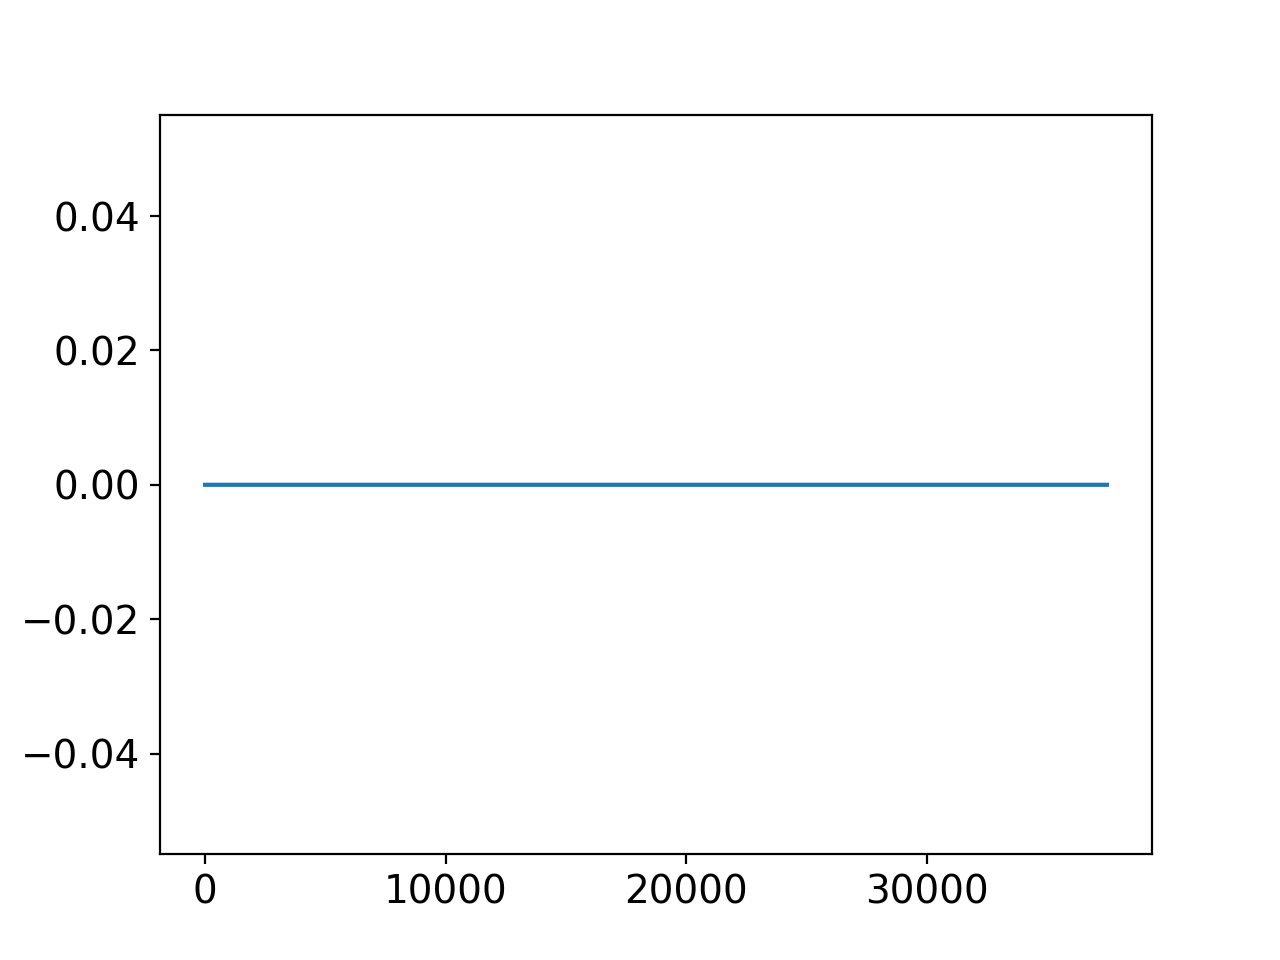

In [12]:
plt.figure()
plt.plot(tip_radial_pos)